In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
import joblib
import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
DATA_PATH = 'data_2/'

## Task-1 Exploratory Data Analysis & Feature generation

In [4]:
stores = pd.read_csv(DATA_PATH+'stores.csv')
train = pd.read_csv(DATA_PATH+'train.csv', parse_dates=['Date'])
features = pd.read_csv(DATA_PATH+'features.csv', parse_dates=['Date'])

In [5]:
data = pd.merge(pd.merge(train, features), stores)

In [6]:
data['Week_of_Year'] = data.Date.dt.week
data['Year'] = data.Date.dt.year

In [7]:
data = data.sort_values(by=['Date','Store','Dept']).reset_index(drop=True)

In [8]:
local_train, local_test = data.iloc[:305982], data.loc[(data.Date.dt.year==2012) & (data.Week_of_Year>=5)]

#### 1.1 What is the store (Store ID) with the biggest total sales in September 2011; smallest total sales in January 2011? (two numbers divided by a comma, e.g. 1, 2)?

In [9]:
data[(data.Date.dt.year==2011) & (data.Date.dt.month==9)].groupby(by='Store').Weekly_Sales.sum().idxmax()

4

In [10]:
data[(data.Date.dt.year==2011) & (data.Date.dt.month==1)].groupby(by='Store').Weekly_Sales.sum().idxmin()

33

#### 1.2 Did the store with the largest sales in March change from 2010 to 2011; from 2011 to 2012?

In [11]:
data[(data.Date.dt.year==2010) & (data.Date.dt.month==3)].groupby(by='Store').Weekly_Sales.sum().idxmax()

14

In [12]:
data[(data.Date.dt.year==2011) & (data.Date.dt.month==3)].groupby(by='Store').Weekly_Sales.sum().idxmax()

4

In [13]:
data[(data.Date.dt.year==2012) & (data.Date.dt.month==3)].groupby(by='Store').Weekly_Sales.sum().idxmax()

4

#### 1.3 How many departments have substantially larger sales during holidays (>= 200%) compared to regular weeks (averaged over all train period, over all stores)? (single integer number, e.g. 1)

In [14]:
holiday = local_train[local_train.IsHoliday==True].groupby('Dept').Weekly_Sales.mean()
regular = local_train[local_train.IsHoliday==False].groupby('Dept').Weekly_Sales.mean()
df = pd.DataFrame([holiday,regular], index=['holiday_week','regular_week']).T
larger_sales = df.index[df.holiday_week >= 2*df.regular_week]
larger_sales

Int64Index([47, 72, 77, 99], dtype='int64', name='Dept')

#### 1.4 How many departments have substantially smaller sales during holidays (<=50%) compared to regular weeks (averaged over all train period, over all stores)? (single integer number, e.g. 1)

In [15]:
holiday = local_train[local_train.IsHoliday==True].groupby('Dept').Weekly_Sales.mean()
regular = local_train[local_train.IsHoliday==False].groupby('Dept').Weekly_Sales.mean()
df = pd.DataFrame([holiday,regular], index=['holiday_week','regular_week']).T
smaller_sales = df.index[df.holiday_week <= 0.5*df.regular_week]
smaller_sales

Int64Index([16, 43, 56], dtype='int64', name='Dept')

#### 1.5 Generate new attribute `Department_Type` (1,2,3) <...> How many departments of each type do you have? (3 integer numbers, divided by comma, e.g. 1, 2, 3)

In [16]:
local_train = local_train.assign(Department_Type=2*np.ones((local_train.shape[0],)))
local_train.loc[local_train.Dept.isin(smaller_sales),'Department_Type'] = 1
local_train.loc[local_train.Dept.isin(larger_sales),'Department_Type'] = 3

In [17]:
local_train.groupby('Dept').first().reset_index().groupby('Department_Type').Dept.count()

Department_Type
1.0     3
2.0    74
3.0     4
Name: Dept, dtype: int64

In [18]:
local_test = local_test.assign(Department_Type=2*np.ones((local_test.shape[0],)))
local_test.loc[local_test.Dept.isin(smaller_sales),'Department_Type'] = 1
local_test.loc[local_test.Dept.isin(larger_sales),'Department_Type'] = 3

#### 1.6 Compute correlation between total `Weekly_Sales` (in millions) over all training set and `Size`. (single number rounded to 3 decimal places, e.g. 0.001)

In [19]:
df_store_size = local_train.groupby('Size').Weekly_Sales.sum().reset_index()
df_store_size.Weekly_Sales = df_store_size.Weekly_Sales/10**6
df_store_size.Weekly_Sales.corr(df_store_size.Size).round(3)

0.719

#### 1.7 Plot a scatter plot total (over all training set) `Weekly_Sales` (in millions) in a store vs `Size` of the store.

Text(0.5, 1.0, 'Scatter Plot between Weekly_Sales (in millions) and Size')

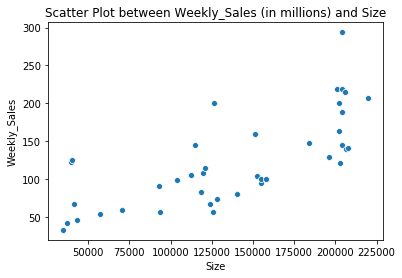

In [20]:
ax = sns.scatterplot(x="Size", y="Weekly_Sales", data=df_store_size)
ax.set_title('Scatter Plot between Weekly_Sales (in millions) and Size')

#### 1.8 Plot a boxplot of `Weekly_Sales` for different store types (3 boxes, one for every Type). For this plot filter out all `Weekly_Sales` bigger than 70000.

Text(0.5, 1.0, 'Boxplot of Weekly_Sales for different store types')

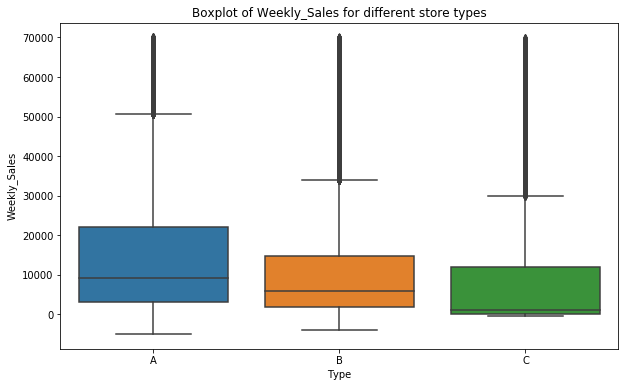

In [21]:
fig = plt.figure(figsize=(10,6))
ax = sns.boxplot(x="Type", y="Weekly_Sales", data=local_train[local_train.Weekly_Sales<=70000].loc[:,['Weekly_Sales','Type']])
ax.set_title('Boxplot of Weekly_Sales for different store types')

#### 1.9 Find Stores with Type == `B` which have total `Weekly_Sales`, (in millions) over all training set, more than 80% percentile of `Weekly_Sales` of stores with Type == `A`. (List of store IDs, e.g. 1, 2, 3)

In [22]:
type_A = local_train[local_train.Type=='B'].groupby('Store').Weekly_Sales.sum()/10**6
type_B = local_train[local_train.Type=='A'].groupby('Store').Weekly_Sales.sum()/10**6
type_B.where(type_B > type_A.quantile(0.8)).dropna().index

Int64Index([1, 2, 4, 6, 11, 13, 14, 19, 20, 24, 27, 28, 31, 32, 39, 41], dtype='int64', name='Store')

#### 1.10 Generate new attribute `Total_Sales_Store_Type`. 5 (from 1 to 5) groups generated using percentiles (0<=p<20, 20<=p<40, 40<=p<60, 60<=p<80, 80<=p<=100) of total `Weekly_Sales` (in millions) over all training set. How many stores of each type do you have? (5 numbers from 1 to 5 type). 

In [23]:
total_sales = local_train.groupby('Store').Weekly_Sales.sum()/10**6
p1 = total_sales.quantile(0.2)
group_1 = dict.fromkeys(total_sales.where(total_sales<p1).dropna().index,1)
p2 = total_sales.quantile(0.4)
group_2 = dict.fromkeys(total_sales.where((total_sales>=p1)&(total_sales<p2)).dropna().index,2)
p3 = total_sales.quantile(0.6)
group_3 = dict.fromkeys(total_sales.where((total_sales>=p2)&(total_sales<p3)).dropna().index,3)
p4 = total_sales.quantile(0.8)
group_4 = dict.fromkeys(total_sales.where((total_sales>=p3)&(total_sales<p4)).dropna().index,4)
p5 = total_sales.quantile(1.0)
group_5 = dict.fromkeys(total_sales.where((total_sales>=p4)&(total_sales<=p5)).dropna().index,5)

In [24]:
print('Group-1', len(group_1))
print('Group-2', len(group_2))
print('Group-3', len(group_3))
print('Group-4', len(group_4))
print('Group-5', len(group_5))

Group-1 9
Group-2 9
Group-3 9
Group-4 9
Group-5 9


In [25]:
local_train.loc[:,'Total_Sales_Store_Type'] = local_train.Store.map({**group_1,**group_2,**group_3,**group_4,**group_5}) 

In [26]:
local_test.loc[:,'Total_Sales_Store_Type'] = local_test.Store.map({**group_1,**group_2,**group_3,**group_4,**group_5}) 

#### 1.11 How many holidays’ weeks are in the train set; test set? (two integer numbers, divided by comma)

In [27]:
local_train[local_train.IsHoliday==True].groupby(['Date']).IsHoliday.count().shape

(8,)

In [28]:
local_test[local_test.IsHoliday==True].groupby(['Date']).IsHoliday.count().shape

(2,)

#### 1.12 Generate 5 separate attributes (nominal True-False or 1-0): `Is_SuperBowl`, <...>. How many `Other_holidays` weeks do you have in the whole training set?

In [29]:
local_train = local_train.assign(Is_SuperBowl=0)
local_train = local_train.assign(Is_BlackFriday=0)
local_train = local_train.assign(Is_Christmas=0)
local_train = local_train.assign(Other_holidays=0)
local_train = local_train.assign(Regular_weeks=0)

local_test = local_test.assign(Is_SuperBowl=0)
local_test = local_test.assign(Is_BlackFriday=0)
local_test = local_test.assign(Is_Christmas=0)
local_test = local_test.assign(Other_holidays=0)
local_test = local_test.assign(Regular_weeks=0)

In [30]:
SuperBowl = pd.Series(['2010-02-12', '2011-02-11', '2012-02-10', '2013-02-08'])
BlackFriday = pd.Series(['2010-11-26', '2011-11-25', '2012-11-23', '2013-11-29'])
Christmas = pd.Series(['2010-12-31', '2011-12-30', '2012-12-28', '2013-12-27'])
Not_Other_holidays = pd.concat([SuperBowl,BlackFriday,Christmas]).reset_index(drop=True)

In [31]:
local_train.loc[local_train.Date.isin(SuperBowl),'Is_SuperBowl'] = 1
local_train.loc[local_train.Date.isin(BlackFriday),'Is_BlackFriday'] = 1
local_train.loc[local_train.Date.isin(Christmas),'Is_Christmas'] = 1
local_train.loc[(~local_train.Date.isin(Not_Other_holidays))&(local_train.IsHoliday),'Other_holidays'] = 1
local_train.loc[(~local_train.Date.isin(Not_Other_holidays))&(~local_train.IsHoliday),'Regular_weeks'] = 1

local_test.loc[local_test.Date.isin(SuperBowl),'Is_SuperBowl'] = 1
local_test.loc[local_test.Date.isin(BlackFriday),'Is_BlackFriday'] = 1
local_test.loc[local_test.Date.isin(Christmas),'Is_Christmas'] = 1
local_test.loc[(~local_test.Date.isin(Not_Other_holidays))&(local_test.IsHoliday),'Other_holidays'] = 1
local_test.loc[(~local_test.Date.isin(Not_Other_holidays))&(~local_test.IsHoliday),'Regular_weeks'] = 1

In [32]:
local_train[local_train.Other_holidays==1].groupby(['Date']).Other_holidays.count().shape[0] + local_test[local_test.Other_holidays==1].groupby(['Date']).Other_holidays.count().shape[0]

3

#### 1.13 Select 10 Stores with highest total Sales in 2011. Compute the percentage of Sales during Black Friday week compared to total Sales; during Super Bowl week; during Christmas week. (three integer numbers 0-100, e.g. 99)

In [33]:
top_10 = local_train[local_train.Date.dt.year == 2011].groupby('Store').Weekly_Sales.sum().sort_values(ascending=False)[:10]

In [34]:
black_fri = local_train[local_train.Store.isin(top_10.index) & (local_train.Date.dt.year == 2011) & local_train.Is_BlackFriday].groupby('Store').Weekly_Sales.sum()
round(black_fri.sum()*100/top_10.sum())

3.0

In [35]:
SuperBowl = local_train[local_train.Store.isin(top_10.index) & (local_train.Date.dt.year == 2011) & local_train.Is_SuperBowl].groupby('Store').Weekly_Sales.sum()
round(SuperBowl.sum()*100/top_10.sum())

2.0

In [36]:
Christmas = local_train[local_train.Store.isin(top_10.index) & (local_train.Date.dt.year == 2011) & local_train.Is_Christmas].groupby('Store').Weekly_Sales.sum()
round(Christmas.sum()*100/top_10.sum())

2.0

#### 1.14 Select 10 Stores with lowest total Sales in 2011. Compute the percentage of Sales during Black Friday week compared to total Sales; during Super Bowl week; during Christmas week. (three integer numbers 0-100, e.g. 99)

In [37]:
bottom_10 = local_train[local_train.Date.dt.year == 2011].groupby('Store').Weekly_Sales.sum().sort_values(ascending=True)[:10]

In [38]:
black_fri = local_train[local_train.Store.isin(bottom_10.index) & (local_train.Date.dt.year == 2011) & local_train.Is_BlackFriday].groupby('Store').Weekly_Sales.sum()
round(black_fri.sum()*100/bottom_10.sum())

2.0

In [39]:
SuperBowl = local_train[local_train.Store.isin(bottom_10.index) & (local_train.Date.dt.year == 2011) & local_train.Is_SuperBowl].groupby('Store').Weekly_Sales.sum()
round(SuperBowl.sum()*100/bottom_10.sum())

2.0

In [40]:
Christmas = local_train[local_train.Store.isin(bottom_10.index) & (local_train.Date.dt.year == 2011) & local_train.Is_Christmas].groupby('Store').Weekly_Sales.sum()
round(Christmas.sum()*100/bottom_10.sum())

2.0

#### 1.15 Plot a linear graph of temperature over time (averaged over all stores). 

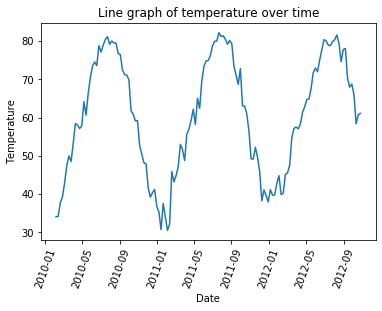

In [41]:
df = data.groupby(['Date','Store']).last().groupby('Date').Temperature.mean().reset_index()
ax = sns.lineplot(x="Date", y="Temperature", data = df[['Temperature','Date']])
ax.set_title('Line graph of temperature over time')
plt.xticks(rotation=70)
plt.show()

#### 1.16 Plot a scatter plot of `Temperature` vs `Weekly_Sales` (every point corresponds to a single date, a single store). Compute correlation between them. (single number rounded to 3 decimal places, e.g. 0.001)

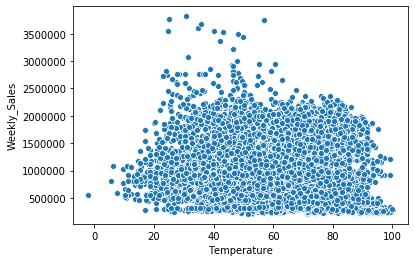

In [42]:
df = pd.merge(data.groupby(['Date','Store']).Weekly_Sales.sum().reset_index(),
              data.groupby(['Date','Store']).Temperature.first().reset_index())
sns.scatterplot(x='Temperature',y='Weekly_Sales',data=df)

In [43]:
df.Temperature.corr(df.Weekly_Sales).round(3)

-0.064

#### 1.17 Find 2 stores with the biggest difference in temperature in July 2010. (two stores ID, e.g. 1, 2)

In [44]:
df = data[(data.Date.dt.year==2010) & (data.Date.dt.month==7)].sort_values(by=['Store','Temperature'])
(df.groupby(['Store']).last().Temperature-df.groupby(['Store']).first().Temperature).sort_values(ascending=False)[:2]

Store
23    12.40
26    12.18
Name: Temperature, dtype: float64

#### 1.18 Plot a linear graph of temperature over time for these two stores, use different colors for different stores. 

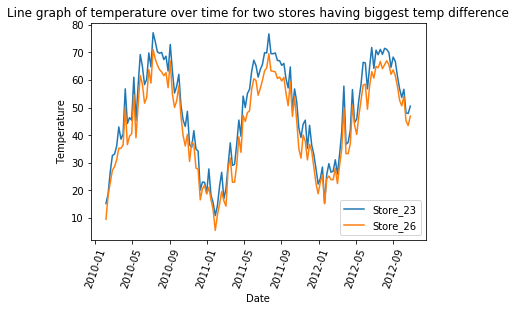

In [45]:
ax = sns.lineplot(x="Date", y="Temperature", data = data.loc[data.Store==23, ['Temperature','Date']].groupby('Date').Temperature.first().reset_index(), label='Store_23')
ax = sns.lineplot(x="Date", y="Temperature", data = data.loc[data.Store==26, ['Temperature','Date']].groupby('Date').Temperature.first().reset_index(), label='Store_26')
ax.set_title('Line graph of temperature over time for two stores having biggest temp difference')
plt.xticks(rotation=70)
plt.show()

#### 1.19 Plot a scatter plot of `Temperature` vs `Weekly_Sales`, use different colors for points corresponding to different stores. Compute correlation between temperature and sales separately for each of 2 stores. (two numbers rounded to 3 decimal places, e.g. 0.001, 0.002)

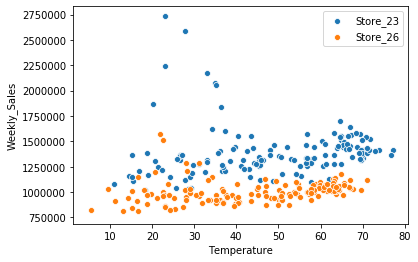

In [46]:
df1 = data.loc[(data.Store==23)].groupby(['Date','Temperature']).Weekly_Sales.sum().reset_index()
df2 = data.loc[(data.Store==26)].groupby(['Date','Temperature']).Weekly_Sales.sum().reset_index()
sns.scatterplot(x='Temperature', y='Weekly_Sales', data=df1, label='Store_23')
sns.scatterplot(x='Temperature', y='Weekly_Sales', data=df2, label='Store_26')

In [47]:
df1.Temperature.corr(df1.Weekly_Sales).round(3)

0.056

In [48]:
df2.Temperature.corr(df2.Weekly_Sales).round(3)

0.212

#### Generate new attribute `Average_Temperature_month`: average temperature over current month for this particular store. 
You may use any reasonable approach: e.g. for the current week average of the last 4 weeks, or average of all weeks from the same month one year ago.

In [49]:
lookup = local_train.assign(month=local_train.Date.dt.month).groupby(['Store','month']).Temperature.mean()

In [50]:
local_train['Average_Temperature_month'] = local_train.assign(month=local_train.Date.dt.month)[['Store','month']].apply(lambda row: lookup.loc[tuple(row)],axis=1)

In [51]:
local_test['Average_Temperature_month'] = local_test.assign(month=local_test.Date.dt.month)[['Store','month']].apply(lambda row: lookup.loc[tuple(row)],axis=1)

#### Sample Weight

In [52]:
local_train['weight'] = local_train.IsHoliday.map({True:5, False:1})
local_test['weight'] = local_test.IsHoliday.map({True:5, False:1})

#### Drop `Fuel_Price`, `MarkDown1`, `MarkDown2`, `MarkDown3`, `MarkDown4`, `MarkDown5`, `CPI`, `Unemployment`, `Temperature` as they only appears for the downloaded train table (they are not available for the “future”); Drop `Is_Holiday` and `Type` attribute; . 


In [53]:
local_train = local_train.drop(['Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Temperature', 'IsHoliday', 'Type'], axis=1)
local_test = local_test.drop(['Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Temperature', 'IsHoliday', 'Type'], axis=1)

## Task-2 Building a regression model

In [54]:
X_train = local_train.loc[:,~local_train.columns.isin(['Weekly_Sales','Date','weight'])]
y_train = local_train.Weekly_Sales
weight_train = local_train['weight']
X_test = local_test.loc[:,~local_test.columns.isin(['Weekly_Sales','Date','weight'])]
y_test = local_test.Weekly_Sales
weight_test = local_test['weight']

#### 2.1 Compute performance of your model on a test set; on a train set. Use wMAE (absolute_error in RM, mean_absolute_error in sklearn). What is the difference between train score and test score? (single number rounded to 3 decimal places, e.g. 123.456)

In [55]:
model = RandomForestRegressor(n_estimators=10, max_depth=10)
model.fit(X_train, y_train, sample_weight=weight_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [56]:
y_pred = model.predict(X_train)
wMAE_train = mean_absolute_error(y_train, y_pred, sample_weight=weight_train)

In [57]:
y_pred = model.predict(X_test)
wMAE_test = mean_absolute_error(y_test, y_pred, sample_weight=weight_test)

In [58]:
round(wMAE_train - wMAE_test,3)

100.533

#### 2.2 What are the resulting parameters of the best model? (3 numbers, e.g. 5, 2, 0.1)

In [59]:
sample = pd.DataFrame()
for store in range(1,46):
    sample = pd.concat([sample, local_train[local_train.Store==store].sample(frac=0.1, random_state=1000)])
X_sample = sample.loc[:,~sample.columns.isin(['Weekly_Sales','Date','weight'])]
y_sample = sample.Weekly_Sales
sample_weight = sample.weight.to_list()

In [60]:
estimator = RandomForestRegressor()
param_grid = {'n_estimators':range(5,50,2), 
              'max_depth':range(2,20), 
              'max_features':np.arange(0.1,1.0,0.1),
             }
classifier = GridSearchCV(estimator, param_grid, n_jobs=-1, verbose=1000)
classifier.fit(X_sample, y_sample, sample_weight=sample.weight)
joblib.dump(classifier, DATA_PATH+'model_10_percent.sav')

In [61]:
loaded_model = joblib.load(DATA_PATH+'model_10_percent.sav')

In [62]:
best_estimator = loaded_model.best_estimator_
best_estimator

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=19, max_features=0.6, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=31, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

#### 2.3 What is the difference between train score and test score? (single number rounded to 3 decimal places, e.g. 123.456)

In [63]:
y_pred = best_estimator.predict(X_train)
wMAE_train = mean_absolute_error(y_train, y_pred, sample_weight=weight_train)

y_pred = best_estimator.predict(X_test)
wMAE_test = mean_absolute_error(y_test,y_pred, sample_weight=weight_test)

round(wMAE_train - wMAE_test,3)

493.109

#### 2.4 What is the difference between test score using default parameters (II.1.b) and the test score using parameters obtained using GridSearch? (single number rounded to 3 decimal places, e.g. 123.456)

In [64]:
y_pred = model.predict(X_test)
wMAE_test_1 = mean_absolute_error(y_test,y_pred,sample_weight=weight_test)

y_pred = best_estimator.predict(X_test)
wMAE_test_2 = mean_absolute_error(y_test,y_pred,sample_weight=weight_test)

round(wMAE_test_1 - wMAE_test_2,3)

1319.676

In [65]:
model.score(X_train, y_train, sample_weight=weight_train)

0.8900072258682644

## Task 3 - Analyzing the resulting model

#### 3.1 Analyze the results for different Stores: 
a) Compute wMAE separately for Stores of different types (`Total_Sales_Store_Type`). 

b) Is there any difference between errors obtained for different types of Stores? Plot a boxplot or bar plot of errors distribution (1 box/bar for every week type).


In [66]:
wMAEs = pd.DataFrame()
data = pd.concat([local_train, local_test])
for store_type in data.Total_Sales_Store_Type.unique():
    sample = data[data.Total_Sales_Store_Type == store_type]
    sample_weight = sample.weight
    X = sample.loc[:,~sample.columns.isin(['Weekly_Sales','Date','weight'])]
    y = sample.Weekly_Sales
    y_pred = best_estimator.predict(X)
    wMAE = mean_absolute_error(y, y_pred, sample_weight=sample_weight)
    wMAEs = wMAEs.append(pd.Series({'Total_Sales_Store_Type':str(store_type), 'wMAE':wMAE, 'Number of Instances':str(int(sample.shape[0]))}), ignore_index=True)

In [67]:
wMAEs

,Number of Instances,Total_Sales_Store_Type,wMAE
0,92233,5,5254.741462
1,69080,1,1775.510362
2,80712,2,2334.333414
3,88634,3,3199.978581
4,90911,4,3871.463128


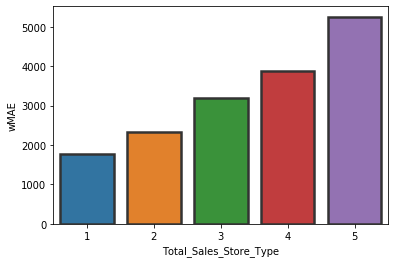

In [68]:
sns.barplot(x='Total_Sales_Store_Type', y='wMAE', data=wMAEs, linewidth=2.5, errcolor=".2", edgecolor=".2")

#### Observation:
As we can observe that number of instances/examples in the data-set of each store type are different. Among all the store types, type-1 has less number of instances in the data-set on the other hand type-5 has highest number of instances in the data-set. We can also observe that wMAE is proportionally increasing with the number of instances/examples of each type of store.

#### 3.2 Analyze the results for different Departments (Dpt).
a) Compute wMAE separately for different Department types (`Department_Type`). 

b) Is there any difference between errors obtained for different types of departments? Plot a boxplot or bar plot of errors distribution (1 box/bar for every week type).


In [69]:
wMAEs = pd.DataFrame()
data = pd.concat([local_train, local_test])
for dept_type in data.Department_Type.unique():
    sample = data[data.Department_Type == dept_type]
    sample_weight = sample.weight
    X = sample.loc[:,~sample.columns.isin(['Weekly_Sales','Date','weight'])]
    y = sample.Weekly_Sales
    y_pred = best_estimator.predict(X)
    wMAE = mean_absolute_error(y, y_pred, sample_weight=sample_weight)
    wMAEs = wMAEs.append(pd.Series({'Department_Type':str(int(dept_type)), 'wMAE':wMAE, 'Number of Instances':str(int(sample.shape[0]))}), ignore_index=True)

In [70]:
wMAEs

,Department_Type,Number of Instances,wMAE
0,2,401547,3111.226028
1,1,12319,3211.441797
2,3,7704,18021.163880


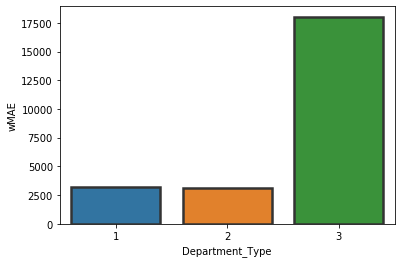

In [71]:
sns.barplot(x='Department_Type', y='wMAE', data=wMAEs, linewidth=2.5, errcolor=".2", edgecolor=".2")

#### Observation:
In case of different types, we can observe that dept-3 has lowest number of instances and highest wMAE. So, we can conclude that due to less number of instances/examples of dept-3, model couldn’t learn very well on that department.


#### 3.5 Make an overall conclusion. Your conclusion should include answers to (but not limited to) the following questions:
a) How good is your final model for small/huge stores?

b) What kind of additional features could you suggest for this task? 

c) Would you suggest building individual models for Stores/Departments/Regular-Holiday weeks/Nearest-Farthest weeks?

d) Which features were most useful? Least useful?


In [72]:
data = pd.concat([local_train, local_test])
small_stores = sorted(local_train.Size.unique())[:5]
small = data[data.Size.isin(small_stores)]
sample_weight = small.weight
X = small.loc[:,~small.columns.isin(['Weekly_Sales','Date','weight'])]
y = small.Weekly_Sales
y_pred = best_estimator.predict(X)
wMAE = mean_absolute_error(y, y_pred, sample_weight=sample_weight)
score = best_estimator.score(X, y, sample_weight=sample_weight)
wMAE, score

(1785.4351312644076, 0.8427396585989327)

In [73]:
huge_stores = sorted(local_train.Size.unique())[-5:]
huge = data[data.Size.isin(huge_stores)]
sample_weight = huge.weight
X = huge.loc[:,~huge.columns.isin(['Weekly_Sales','Date','weight'])]
y = huge.Weekly_Sales
y_pred = best_estimator.predict(X)
wMAE = mean_absolute_error(y, y_pred, sample_weight=sample_weight)
score = best_estimator.score(X, y, sample_weight=sample_weight)
wMAE, score

(4538.235007974239, 0.8893822546418253)

In [74]:
features = list(zip(X_train.columns,best_estimator.feature_importances_))
features.sort(key=lambda x: x[1])
features

[('Is_Christmas', 0.0022116467908033875),
 ('Is_SuperBowl', 0.0022248122905002736),
 ('Other_holidays', 0.0024305671091564636),
 ('Regular_weeks', 0.010858750247163042),
 ('Year', 0.013202926002506317),
 ('Average_Temperature_month', 0.04414015978544416),
 ('Week_of_Year', 0.0455384818536372),
 ('Store', 0.04833968073707328),
 ('Is_BlackFriday', 0.05205799512520924),
 ('Department_Type', 0.05360258708987602),
 ('Total_Sales_Store_Type', 0.07956773880658465),
 ('Size', 0.1256155027140977),
 ('Dept', 0.5202091514479482)]

## Bonus
#### 2.4 Train separate models for different types of weeks: holidays’ weeks and regular.
You may train separate models for every type of week (Christmas, etc), but you probably lack training data for all weeks except regular.

a) Tune every model using Grid Search as in II.2. 

b) Make predictions on a test set; train set, save results to file. (you will need them in part III)

c) Compute train and test performance using wMAE.


#### Holidays’ weeks Model

In [75]:
holiday_train = local_train[(local_train.Is_SuperBowl==1)|(local_train.Is_BlackFriday==1)|(local_train.Is_Christmas==1)|local_train.Other_holidays==1]
holiday_test = local_test[(local_test.Is_SuperBowl==1)|(local_test.Is_BlackFriday==1)|(local_test.Is_Christmas==1)|local_test.Other_holidays==1]

sample = pd.DataFrame()
for store in range(1,46):
    sample = pd.concat([sample, holiday_train[holiday_train.Store==store].sample(frac=0.5, random_state=1000)])
X_sample = sample.loc[:,~sample.columns.isin(['Weekly_Sales','Date','weight'])]
y_sample = sample.Weekly_Sales
sample_weight = sample.weight.to_list()

In [76]:
estimator = RandomForestRegressor()
param_grid = {'n_estimators':range(5,50,2), 
              'max_depth':range(2,20), 
              'max_features':np.arange(0.1,1.0,0.1),
             }
classifier = GridSearchCV(estimator, param_grid, n_jobs=-1, verbose=1000)
classifier.fit(X_sample, y_sample, sample_weight=sample.weight)
joblib.dump(classifier, 'model_holidays.sav')

In [77]:
loaded_model = joblib.load(DATA_PATH+'model_holidays.sav')

In [78]:
holidays_estimator = loaded_model.best_estimator_

In [79]:
X_train = holiday_train.loc[:,~holiday_train.columns.isin(['Weekly_Sales','Date','weight'])]
y_train = holiday_train.Weekly_Sales
weight_train= holiday_train.weight
X_test = holiday_test.loc[:,~holiday_test.columns.isin(['Weekly_Sales','Date','weight'])]
y_test = holiday_test.Weekly_Sales
weight_test = holiday_test.weight

In [80]:
y_pred = holidays_estimator.predict(X_train)
wMAE_train = mean_absolute_error(y_train, y_pred, sample_weight=weight_train)

y_pred = holidays_estimator.predict(X_test)
wMAE_test = mean_absolute_error(y_test,y_pred, sample_weight=weight_test)

wMAE_train, wMAE_test

(2593.7820396331763, 2809.400922779725)

In [81]:
#Small Store
data = pd.concat([holiday_train, holiday_test])
small_stores = sorted(data.Size.unique())[:5]
small = data[data.Size.isin(small_stores)]
sample_weight = small.weight
X = small.loc[:,~small.columns.isin(['Weekly_Sales','Date','weight'])]
y = small.Weekly_Sales
y_pred = best_estimator.predict(X)
wMAE = mean_absolute_error(y, y_pred, sample_weight=sample_weight)
score = best_estimator.score(X, y, sample_weight=sample_weight)
wMAE, score

(2990.4509211215004, 0.5382866321719052)

In [82]:
#Huge Store
data = pd.concat([holiday_train, holiday_test])
huge_stores = sorted(data.Size.unique())[-5:]
huge = data[data.Size.isin(huge_stores)]
sample_weight = huge.weight
X = huge.loc[:,~huge.columns.isin(['Weekly_Sales','Date','weight'])]
y = huge.Weekly_Sales
y_pred = best_estimator.predict(X)
wMAE = mean_absolute_error(y, y_pred, sample_weight=sample_weight)
score = best_estimator.score(X, y, sample_weight=sample_weight)
wMAE, score

(6833.759615842565, 0.7997973799711988)

In [83]:
features_imp = list(zip(X_train.columns,best_estimator.feature_importances_))
features_imp.sort(key=lambda x: x[1])

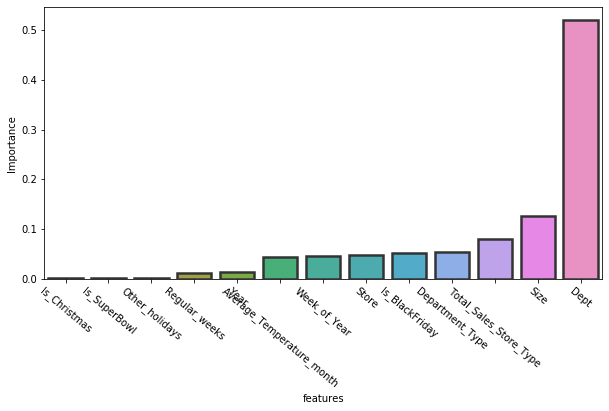

In [84]:
fig = plt.figure(figsize=(10,5))
ax = sns.barplot(x='features', y='Importance', data=pd.DataFrame(features_imp, columns=['features','Importance']), linewidth=2.5, errcolor=".2", edgecolor=".2")
plt.xticks(rotation=-40)
plt.show()

#### Regulars’ weeks Model

In [85]:
regular_train = local_train[local_train.Regular_weeks==1]
regular_test = local_test[local_test.Regular_weeks==1]
sample = pd.DataFrame()
for store in range(1,46):
    sample = pd.concat([sample, local_train[local_train.Store==store].sample(frac=0.1, random_state=1000)])
X_sample = sample.loc[:,~sample.columns.isin(['Weekly_Sales','Date','weight'])]
y_sample = sample.Weekly_Sales
sample_weight = sample.weight.to_list()

In [86]:
estimator = RandomForestRegressor()
param_grid = {'n_estimators':range(5,50,2), 
              'max_depth':range(2,20), 
              'max_features':np.arange(0.1,1.0,0.1),
             }
classifier = GridSearchCV(estimator, param_grid, n_jobs=-1, verbose=1000)

classifier.fit(X_sample, y_sample, sample_weight=sample.weight)

joblib.dump(classifier, 'model_regular.sav')

In [87]:
loaded_model = joblib.load(DATA_PATH+'model_regular.sav')

In [88]:
regular_estimator = loaded_model.best_estimator_

In [89]:
X_train = regular_train.loc[:,~regular_train.columns.isin(['Weekly_Sales','Date','weight'])]
y_train = regular_train.Weekly_Sales
weight_train= regular_train.weight
X_test = regular_test.loc[:,~regular_test.columns.isin(['Weekly_Sales','Date','weight'])]
y_test = regular_test.Weekly_Sales
weight_test = regular_test.weight

In [90]:
y_pred = regular_estimator.predict(X_train)
wMAE_train = mean_absolute_error(y_train, y_pred, sample_weight=weight_train)

y_pred = regular_estimator.predict(X_test)
wMAE_test = mean_absolute_error(y_test,y_pred, sample_weight=weight_test)

wMAE_train, wMAE_test

(2311.7625438250925, 2357.01592029243)

In [91]:
#Small Store
data = pd.concat([regular_train, regular_test])
small_stores = sorted(data.Size.unique())[:5]
small = data[data.Size.isin(small_stores)]
sample_weight = small.weight
X = small.loc[:,~small.columns.isin(['Weekly_Sales','Date','weight'])]
y = small.Weekly_Sales
y_pred = best_estimator.predict(X)
wMAE = mean_absolute_error(y, y_pred, sample_weight=sample_weight)
score = best_estimator.score(X, y, sample_weight=sample_weight)
wMAE, score

(1332.3502905300782, 0.9598129160257235)

In [92]:
#Huge Store
data = pd.concat([regular_train, regular_test])
huge_stores = sorted(data.Size.unique())[-5:]
huge = data[data.Size.isin(huge_stores)]
sample_weight = huge.weight
X = huge.loc[:,~huge.columns.isin(['Weekly_Sales','Date','weight'])]
y = huge.Weekly_Sales
y_pred = best_estimator.predict(X)
wMAE = mean_absolute_error(y, y_pred, sample_weight=sample_weight)
score = best_estimator.score(X, y, sample_weight=sample_weight)
wMAE, score

(3667.1158206726145, 0.936228570547455)

In [93]:
features_imp = list(zip(X_train.columns,best_estimator.feature_importances_))
features_imp.sort(key=lambda x: x[1])

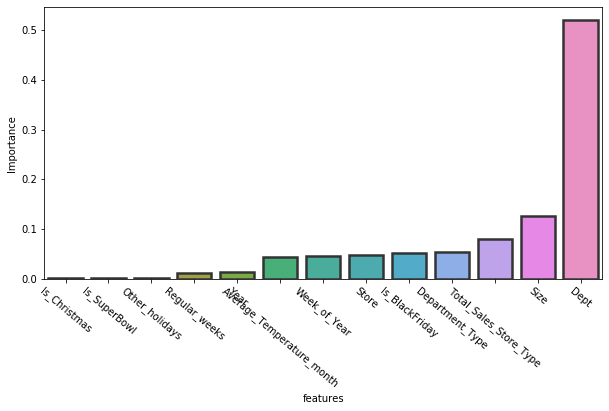

In [94]:
fig = plt.figure(figsize=(10,5))
ax = sns.barplot(x='features', y='Importance', data=pd.DataFrame(features_imp, columns=['features','Importance']), linewidth=2.5, errcolor=".2", edgecolor=".2")
plt.xticks(rotation=-40)
plt.show()